In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
import datetime as dt
import pathlib

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [13]:
# create a reference to the file
database_path = pathlib.Path('C:/Users/lnata/Github/sqlalchemy-challenge/Resources/hawaii.sqlite')

# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

In [14]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=False)

In [15]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [20]:
from datetime import datetime, timedelta
recent_date_str = recent_date[0]

# Convert the string to a datetime object
recent_date_obj = datetime.strptime(recent_date_str, '%Y-%m-%d')

# Calculate the start date by subtracting one year (365 days) from the most recent date
start_date_obj = recent_date_obj - timedelta(days=365)

# Optionally, convert the start date back to a string if needed
start_date_str = start_date_obj.strftime('%Y-%m-%d')

print(f"Start date for analysis: {start_date_str}")

Start date for analysis: 2016-08-23


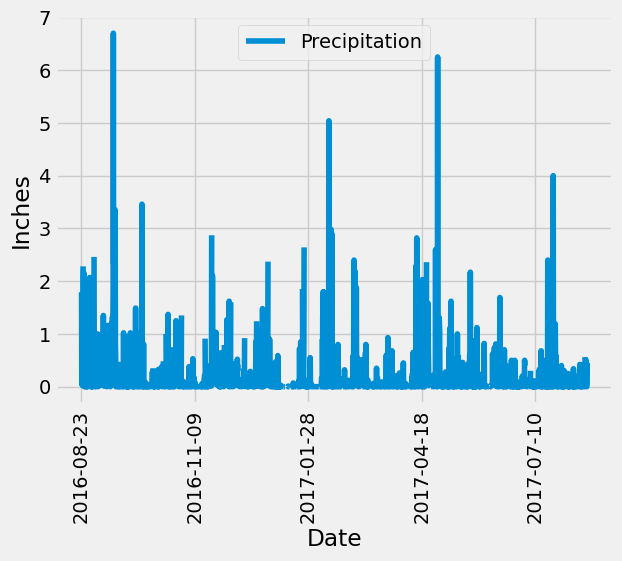

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
scores = [Measurement.date, Measurement.prcp]
precipitation_data = session.query(*scores).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prec_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
prec_df = prec_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(x='Date', y='Precipitation', rot=90)
plt.ylabel("Inches")
plt.show()

In [53]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prec_df['Precipitation'].describe()

print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [55]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station))\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.station).desc())\
                              .all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### Which station id has the greatest number of observations?
The station ID that has the greatest number of observations is "'USC00519281' with a total of 2772 stations.

In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = stations[0][0]

temperatures = session.query(func.min(Measurement.tobs),
                             func.max(Measurement.tobs),
                             func.avg(Measurement.tobs))\
                      .filter(Measurement.station == station_id)\
                      .one()

lowest_temp, highest_temp, average_temp = temperatures

print(lowest_temp, highest_temp, average_temp)

54.0 85.0 71.66378066378067


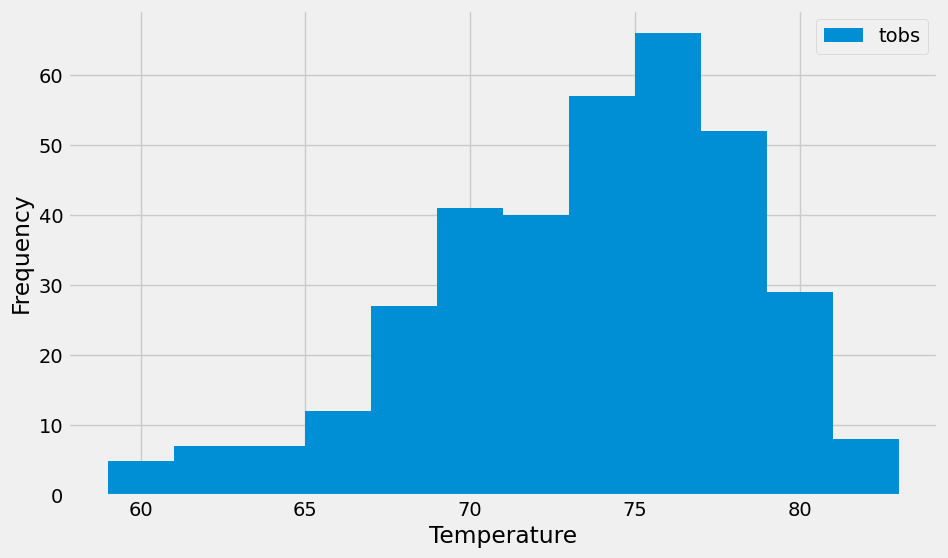

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

from datetime import datetime, timedelta

# Converting the last date to a "datetime" object
last_date = datetime.strptime('2017-08-23', '%Y-%m-%d')

# Calculating the exact date 12 months ago before the last date
date_12_months_ago = last_date - timedelta(days=365)

# Querying the last 12 months of temp observation data for the most active station id 
results = session.query(Measurement.tobs)\
                 .filter(Measurement.station == station_id)\
                 .filter(Measurement.date >= date_12_months_ago)\
                 .all()

# Extracting temperature observations from the query results
temperatures = [temp[0] for temp in results]

# Plot!
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [61]:
# Close Session
session.close()